##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# <a>Algoritmos federados personalizados, parte 2: implementación del promediado federado</a>

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/federated/tutorials/custom_federated_algorithms_2"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">Ver en TensorFlow.org</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/federated/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Ejecutar en Google Colab</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/federated/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">Ver fuente en GitHub</a>
</td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/federated/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar el bloc de notas</a></td>
</table>

Este tutorial es la segunda parte de una serie de dos partes que demuestra cómo implementar tipos personalizados de algoritmos federados en TFF con la ayuda de [Federated Core (FC)](../federated_core.md), que sirve como base para la capa de [Aprendizaje Federado (FL)](../federated_learning.md) (`tff.learning`).

Le recomendamos que lea primero la [primera parte de esta serie](custom_federated_algorithms_1.ipynb), que presenta algunos de los conceptos clave y las abstracciones de programación que se utilizan aquí.

Esta segunda parte de la serie emplea los mecanismos introducidos en la primera parte para implementar una versión simple de algoritmos federados de entrenamiento y evaluación.

Le recomendamos que revise los tutoriales de [clasificación de imágenes](federated_learning_for_image_classification.ipynb) y [generación de texto](federated_learning_for_text_generation.ipynb) para obtener una introducción más sencilla y de mayor nivel a las API de aprendizaje federado de TFF, ya que le ayudarán a poner en contexto los conceptos que describimos en este apartado.

## Antes de empezar

Antes de empezar, intente ejecutar el siguiente ejemplo de "Hola mundo" para asegurarse de que su entorno esté configurado correctamente. Si no funciona, consulte la guía de [instalación](../install.md) para acceder a las instrucciones.

In [ ]:
#@test {"skip": true}
!pip install --quiet --upgrade tensorflow-federated

In [1]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

In [2]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

b'Hello, World!'

## Cómo implementar el promediado federado

Al igual que en [Aprendizaje federado para clasificación de imágenes](federated_learning_for_image_classification.ipynb), usaremos el ejemplo MNIST, pero como está pensado como un tutorial de bajo nivel, omitiremos la API de Keras y `tff.simulation`, escribiremos código de modelo sin formato y construiremos un conjunto de datos federados desde cero.


### Cómo preparar conjuntos de datos federados

A modo de demostración, vamos a simular un escenario en el que contamos con datos de 10 usuarios y cada uno de los usuarios aporta conocimientos sobre cómo reconocer un dígito diferente. Esto es lo menos [IID](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) posible.

En primer lugar, carguemos los datos MNIST estándar:

In [3]:
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

In [4]:
[(x.dtype, x.shape) for x in mnist_train]

[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

Los datos vienen como arreglos Numpy, uno con imágenes y otro con etiquetas de dígitos, ambos con la primera dimensión rque abarca los ejemplos individuales. Escribamos una función ayudante que les dé un formato compatible con la forma en que cargamos secuencias federadas en los cálculos TFF, es decir, como una lista de listas: la lista externa abarca los usuarios (dígitos), las internas abarcan lotes de datos en la secuencia de cada cliente. Como es habitual, estructuraremos cada lote como un par de tensores denominados `x` e `y`, cada uno con la dimensión principal del lote. Mientras lo hacemos, también aplanaremos cada imagen en un vector de 784 elementos y cambiaremos la escala de los píxeles al intervalo `0..1`, para no tener que saturar la lógica del modelo con conversiones de datos.

In [5]:
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100


def get_data_for_digit(source, digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x':
            np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                     dtype=np.float32),
        'y':
            np.array([source[1][i] for i in batch_samples], dtype=np.int32)
    })
  return output_sequence


federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]

federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]

Como comprobación rápida del estado, observemos el tensor `Y` en el último lote de datos que aportó el quinto cliente (el correspondiente al dígito `5`).

In [6]:
federated_train_data[5][-1]['y']

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

Para estar seguros, veamos también la imagen correspondiente al último elemento de ese lote.

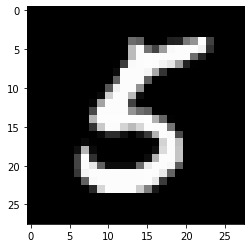

In [7]:
from matplotlib import pyplot as plt

plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28, 28), cmap='gray')
plt.grid(False)
plt.show()

### Sobre la combinación de TensorFlow y TFF

En este tutorial, para que sea más compacto, decoramos inmediatamente funciones que introducen la lógica de TensorFlow con `tff.tf_computation`. Sin embargo, para una lógica más compleja, no recomendamos ese patrón. Depurar TensorFlow ya de por sí puede ser todo un reto, y depurar TensorFlow después de que se haya serializado completamente para luego reimportarlo implica la pérdida de algunos metadatos y limita la interactividad, lo que hace que la depuración sea un reto aún mayor.

Por lo tanto, le **recomendamos enfáticamente que escriba lógica TF compleja como funciones de Python independientes** (es decir, sin el decorador `tff.tf_computation`). De esta manera, la lógica de TensorFlow se puede desarrollar y poner a prueba con las mejores prácticas y herramientas de TF (como el modo eager), antes de serializar el cálculo para TFF (por ejemplo, invocando `tff.tf_computation` con una función de Python como argumento).

### Cómo definir una función de pérdida

Ahora que tenemos los datos, definamos una función de pérdida que podamos usar para el entrenamiento. Primero, definamos el tipo de entrada como una tupla nombrada de TFF. Dado que el tamaño de los lotes de datos puede variar, configuramos la dimensión del lote en `None` para indicar que se desconoce el tamaño de esta dimensión.

In [8]:
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

Quizás se pregunte por qué no podemos definir directamente un tipo de Python normal. Recuerde que, como se explica en [la parte 1](custom_federated_algorithms_1.ipynb), si bien podemos expresar la lógica de los cálculos de TFF con Python, en el fondo los cálculos de TFF *no son* Python. El símbolo `BATCH_TYPE` definido anteriormente representa una especificación de tipo abstracto de TFF. Es importante distinguir este tipo *abstracto* de TFF de los tipos *de representación* concretos de Python, por ejemplo, contenedores como `dict` o `collections.namedtuple` que pueden usarse para representar el tipo TFF en el cuerpo de una función de Python. A diferencia de Python, TFF tiene un único constructor de tipo abstracto `tff.StructType` para contenedores tipo tupla, con elementos que pueden nombrarse individualmente o dejarse sin nombrar. Este tipo también sirve para modelar parámetros formales de cálculos, ya que los cálculos de TFF formalmente solo pueden declarar un parámetro y un resultado; verá ejemplos de esto en breve.

Ahora, es momento de definir el tipo TFF de parámetros del modelo, nuevamente como una tupla nombrada TFF de *ponderaciones* y *sesgos*.

In [9]:
MODEL_SPEC = collections.OrderedDict(
    weights=tf.TensorSpec(shape=[784, 10], dtype=tf.float32),
    bias=tf.TensorSpec(shape=[10], dtype=tf.float32))
MODEL_TYPE = tff.to_type(MODEL_SPEC)
print(MODEL_TYPE)

<weights=float32[784,10],bias=float32[10]>


Ahora que ya implementamos esas definiciones, podemos definir la pérdida para un modelo determinado, en un solo lote. Tenga en cuenta el uso del decorador `@tf.function` dentro del decorador `@tff.tf_computation`. Esto nos permite escribir TF con una semántica similar a la de Python, aunque estemos dentro de un contexto `tf.Graph` creado por el decorador `tff.tf_computation`.

In [10]:
# NOTE: `forward_pass` is defined separately from `batch_loss` so that it can 
# be later called from within another tf.function. Necessary because a
# @tf.function  decorated method cannot invoke a @tff.tf_computation.

@tf.function
def forward_pass(model, batch):
  predicted_y = tf.nn.softmax(
      tf.matmul(batch['x'], model['weights']) + model['bias'])
  return -tf.reduce_mean(
      tf.reduce_sum(
          tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1]))

@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
  return forward_pass(model, batch)

Como se esperaba, el cálculo `batch_loss` devuelve la pérdida `float32` a partir del modelo y un único lote de datos. Observe cómo `MODEL_TYPE` y `BATCH_TYPE` se han agrupado en una tupla doble de parámetros formales; puede reconocer el tipo de `batch_loss` como `(<MODEL_TYPE,BATCH_TYPE> -> float32)`.

In [11]:
str(batch_loss.type_signature)

'(<model=<weights=float32[784,10],bias=float32[10]>,batch=<x=float32[?,784],y=int32[?]>> -> float32)'

Como prueba de estado, construyamos un modelo inicial lleno de ceros y calculemos la pérdida en el lote de datos que visualizamos anteriormente.

In [12]:
initial_model = collections.OrderedDict(
    weights=np.zeros([784, 10], dtype=np.float32),
    bias=np.zeros([10], dtype=np.float32))

sample_batch = federated_train_data[5][-1]

batch_loss(initial_model, sample_batch)

2.3025851

Tenga en cuenta que alimentamos el cálculo de TFF con el modelo inicial definido como `dict`, aunque el cuerpo de la función de Python que lo define consume parámetros del modelo como `model['weight']` y `model['bias']`. Los argumentos de la llamada a `batch_loss` no se pasan simplemente al cuerpo de esa función.

¿Qué sucede cuando invocamos `batch_loss`? En la celda anterior donde se definió, ya rastreamos y serializamos el cuerpo de Python de `batch_loss`. TFF actúa como llamador de `batch_loss` en el momento de la definición del cálculo y como objetivo de la invocación en el momento en que se invoca `batch_loss`. En ambas funciones, TFF sirve como puente entre el sistema de tipos de TFF abstractos y los tipos de representación de Python. En el momento de la invocación, TFF aceptará la mayoría de los tipos de contenedores estándar de Python (`dict`, `list`, `tuple`, `collections.namedtuple`, etc.) como representaciones concretas de tuplas abstractas de TFF. Además, aunque como se señaló anteriormente, los cálculos de TFF formalmente solo aceptan un único parámetro, puede usar la sintaxis de llamada familiar de Python con argumentos posicionales o de palabras clave en caso de que el tipo de parámetro sea una tupla; funciona como se esperaba.

### Descenso del gradiente en un solo lote

Ahora, definamos un cálculo que utilice esta función de pérdida para ejecutar un único paso de descenso del gradiente. Tenga en cuenta que, al definir esta función, utilizamos `batch_loss` como subcomponente. Puede invocar un cálculo construido con `tff.tf_computation` dentro del cuerpo de otro cálculo, aunque normalmente esto no es necesario; como se señaló anteriormente, debido a que la serialización pierde algo de información de depuración, a menudo es preferible para cálculos más complejos escribir y probar todo el código de TensorFlow sin el decorador `tff.tf_computation`.

In [13]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
  # Define a group of model variables and set them to `initial_model`. Must
  # be defined outside the @tf.function.
  model_vars = collections.OrderedDict([
      (name, tf.Variable(name=name, initial_value=value))
      for name, value in initial_model.items()
  ])
  optimizer = tf.keras.optimizers.SGD(learning_rate)

  @tf.function
  def _train_on_batch(model_vars, batch):
    # Perform one step of gradient descent using loss from `batch_loss`.
    with tf.GradientTape() as tape:
      loss = forward_pass(model_vars, batch)
    grads = tape.gradient(loss, model_vars)
    optimizer.apply_gradients(
        zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
    return model_vars

  return _train_on_batch(model_vars, batch)

In [14]:
str(batch_train.type_signature)

'(<initial_model=<weights=float32[784,10],bias=float32[10]>,batch=<x=float32[?,784],y=int32[?]>,learning_rate=float32> -> <weights=float32[784,10],bias=float32[10]>)'

Cuando se invoca una función de Python decorada con `tff.tf_computation` dentro del cuerpo de otra función similar, la lógica del cálculo interno de TFF está incorporada (esencialmente, en línea) en la lógica del cálculo externo. Como se señaló anteriormente, si está escribiendo ambos cálculos, probablemente sea preferible hacer que la función interna (`batch_loss` en este caso) sea una Python o `tf.function` normal en lugar de `tff.tf_computation`. Sin embargo, aquí ilustramos que llamar a un `tff.tf_computation` dentro de otro básicamente funciona como se esperaba. Esto puede ser necesario si, por ejemplo, no tiene el código Python que define `batch_loss`, sino solo su representación TFF serializada.

Ahora, apliquemos esta función varias veces al modelo inicial para ver si la pérdida disminuye.

In [15]:
model = initial_model
losses = []
for _ in range(5):
  model = batch_train(model, sample_batch, 0.1)
  losses.append(batch_loss(model, sample_batch))

In [16]:
losses

[0.19690025, 0.13176318, 0.101132266, 0.08273812, 0.0703014]

### Descenso del gradiente en una secuencia de datos locales

Ahora, dado que `batch_train` parece funcionar, escribamos una función de entrenamiento similar `local_train` que consuma la secuencia completa de todos los lotes de un usuario en lugar de solo un lote. Ahora, el nuevo cálculo deberá consumir `tff.SequenceType(BATCH_TYPE)` en lugar de `BATCH_TYPE`.

In [17]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):
  
  # Reduction function to apply to each batch.
  @tff.federated_computation((MODEL_TYPE, tf.float32), BATCH_TYPE)
  def batch_fn(model_with_lr, batch):
    model, lr = model_with_lr
    return batch_train(model, batch, lr), lr

  trained_model, _ = tff.sequence_reduce(
      all_batches, (initial_model, learning_rate), batch_fn
  )
  return trained_model

In [18]:
str(local_train.type_signature)

'(<initial_model=<weights=float32[784,10],bias=float32[10]>,learning_rate=float32,all_batches=<x=float32[?,784],y=int32[?]>*> -> <weights=float32[784,10],bias=float32[10]>)'

Esta breve sección de código contiene varios detalles ocultos, repasémoslos uno por uno.

Primero, si bien podríamos haber implementado esta lógica por completo en TensorFlow y recurrir a `tf.data.Dataset.reduce` para procesar la secuencia de manera similar a como lo hicimos antes, esta vez hemos optado por expresar la lógica en el lenguaje pegamento, como `tff.federated_computation`. Hemos utilizado el operador federado `tff.sequence_reduce` para ejecutar la reducción.

El operador `tff.sequence_reduce` se usa de manera similar a `tf.data.Dataset.reduce`. Puede pensar en él como si fuera esencialmente lo mismo que `tf.data.Dataset.reduce`, pero para usar dentro de cálculos federados, que, como recordará, no pueden contener código de TensorFlow. Es un operador de plantilla con un parámetro formal de 3 tuplas que consta de una *secuencia* de elementos tipo `T`, el estado inicial de la reducción (nos referiremos a él de manera abstracta como *cero*) de algún tipo `U` y el *operador de reducción* de tipo `(<U,T> -> U)` que altera el estado de la reducción procesando un solo elemento. El resultado es el estado final de la reducción, después de procesar todos los elementos en orden secuencial. En nuestro ejemplo, el estado de la reducción es el modelo entrenado con un prefijo de datos y los elementos son lotes de datos.

En segundo lugar, tenga en cuenta que hemos vuelto a usar un cálculo (`batch_train`) como componente dentro de otro (`local_train`), pero no directamente. No podemos usarlo como operador de reducción porque requiere un parámetro adicional: la tasa de aprendizaje. Para resolver esto, definimos un procesamiento federado integrado `batch_fn` que se vincula al parámetro `learning_rate` de `local_train` en su cuerpo. Está permitido que un cálculo secundario definido de esta manera capture un parámetro formal de su cálculo principal siempre que el cálculo secundario no se invoque fuera del cuerpo de su cálculo principal. Puedes considerar este patrón como un equivalente de `functools.partial` en Python.

La implicación práctica de capturar `learning_rate` de esta manera es, por supuesto, que se utiliza el mismo valor de tasa de aprendizaje en todos los lotes.

Ahora, probemos la función de entrenamiento local recién definida en toda la secuencia de datos del mismo usuario que contribuyó con el lote de muestra (dígito `5`).

In [19]:
locally_trained_model = local_train(initial_model, 0.1, federated_train_data[5])

¿Funcionó? Para responder a esta pregunta, tenemos que implementar la evaluación.

### Evaluación local

Aquí hay una forma de implementar la evaluación local sumando las pérdidas en todos los lotes de datos (también podríamos haber calculado el promedio; lo dejaremos como ejercicio para el lector).

In [20]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):

  @tff.tf_computation((MODEL_TYPE, tf.float32), BATCH_TYPE)
  def accumulate_evaluation(model_and_accumulator, batch):
    model, accumulator = model_and_accumulator
    return model, accumulator + batch_loss(model, batch)

  _, total_loss = tff.sequence_reduce(
      all_batches, (model, 0.0), accumulate_evaluation
  )
  return total_loss

In [21]:
str(local_eval.type_signature)

'(<model=<weights=float32[784,10],bias=float32[10]>,all_batches=<x=float32[?,784],y=int32[?]>*> -> float32)'

Nuevamente, hay algunos elementos nuevos ilustrados en este código; repasémoslos uno por uno.

Primero, hemos utilizado dos nuevos operadores federados para procesar secuencias: `tff.sequence_map`, que toma una *función de asignación* `T->U` y una *secuencia* de `T` y emite una secuencia de `U` obtenida mediante la aplicación de la función de asignación puntualmente, y `tff.sequence_sum`, que simplemente agrega todos los elementos. Aquí, asignamos cada lote de datos a un valor de pérdida y luego sumamos los valores de pérdida resultantes para calcular la pérdida total.

Tenga en cuenta que podríamos haber usado `tff.sequence_reduce` nuevamente, pero esta no sería la mejor opción: el proceso de reducción es, por definición, secuencial, mientras que la asignación y la suma se pueden calcular en forma paralela. Cuando se tiene la opción, es mejor seguir con operadores que no limiten las opciones de implementación, de modo que, cuando nuestro cálculo de TFF se compile en el futuro para implementarse en un entorno específico, sea posible aprovechar al máximo todas las oportunidades potenciales para una ejecución más rápida, más escalable y más eficiente de los recursos.

En segundo lugar, tenga en cuenta que, al igual que en `local_train`, la función del componente que necesitamos (`batch_loss`) toma más parámetros de los que espera el operador federado (`tff.sequence_map`), por lo que volvemos a definir un parcial, esta vez en línea, envolviendo directamente una función `lambda` como `tff.federated_computation`. Usar contenedores en línea con una función como argumento es la forma recomendada de usar `tff.tf_computation` para insertar la lógica de TensorFlow en TFF.

Ahora, veamos si nuestro entrenamiento funcionó.

In [22]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[5]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[5]))

initial_model loss = 23.025854
locally_trained_model loss = 0.43484688


De hecho, la pérdida disminuyó. Pero ¿qué pasa si lo evaluamos con los datos de otro usuario?

In [23]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[0]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[0]))

initial_model loss = 23.025854
locally_trained_model loss = 74.50075


Como era de esperar, las cosas empeoraron. El modelo fue entrenado para reconocer `5` y nunca vio un `0`. Esto plantea la pregunta: desde una perspectiva global, ¿cómo influyó el entrenamiento local en la calidad del modelo?

### Evaluación federada

Este es el punto de nuestro viaje donde finalmente volvemos a los tipos federados y los cálculos federados: el tema con el que comenzamos. A continuación, se muestran un par de definiciones de tipos de TFF para el modelo que se origina en el servidor y los datos que permanecen en los clientes.

In [24]:
SERVER_MODEL_TYPE = tff.type_at_server(MODEL_TYPE)
CLIENT_DATA_TYPE = tff.type_at_clients(LOCAL_DATA_TYPE)

Con todas las definiciones que hemos introducido hasta ahora, expresar la evaluación federada en TFF ocupa una sola línea: distribuimos el modelo a los clientes, dejamos que cada cliente invoque la evaluación local en su porción local de datos y luego promediamos la pérdida. A continuación, una manera de escribir esto.

In [25]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
  return tff.federated_mean(
      tff.federated_map(local_eval, [tff.federated_broadcast(model),  data]))

Ya hemos visto ejemplos de `tff.federated_mean` y `tff.federated_map` en escenarios más simples y, a nivel intuitivo, funcionan como se esperaba, pero esta sección de código es más compleja de lo que parece, así que repasémoslo detenidamente.

Primero, analicemos la *opción de permitir que cada cliente invoque la evaluación local en su parte local de datos*. Como recordará de las secciones anteriores, `local_eval` tiene una firma de tipo del formulario `(<MODEL_TYPE, LOCAL_DATA_TYPE> -> float32)`.

El operador federado `tff.federated_map` es una plantilla que acepta como parámetro una tupla doble que consta de la *función de asignación* de algún tipo `T->U` y un valor federado de tipo `{T}@CLIENTS` (es decir, con miembros constituyentes del mismo tipo que el parámetro de la función de asignación) y devuelve un resultado de tipo `{U}@CLIENTS`.

Dado que estamos proporcionando `local_eval` como una función de asignación para aplicar por cliente, el segundo argumento debe ser de tipo federado `{<MODEL_TYPE, LOCAL_DATA_TYPE>}@CLIENTS`, es decir, en la nomenclatura de las secciones anteriores, debería ser una tupla federada. Cada cliente debe tener un conjunto completo de argumentos para `local_eval` como miembro constituyente. En lugar de eso, le proporcionamos una `list` de Python de 2 elementos. ¿Qué está sucediendo aquí?

Efectivamente, este es un ejemplo de una *conversión de tipos implícita* en TFF, similar a las conversiones de tipos implícitas que puede haber encontrado en otros lugares, por ejemplo, cuando se ingresa un `int` a una función que acepta un `float`. La conversión implícita se utiliza poco en este momento, pero planeamos hacerla más generalizada en TFF como una forma de minimizar el texto repetitivo.

La conversión implícita que se aplica en este caso es la equivalencia entre tuplas federadas de la forma `{<X,Y>}@Z` y tuplas de valores federados `<{X}@Z,{Y}@Z>`. Si bien formalmente, se trata de firmas de tipos diferentes, mirándolo desde la perspectiva de los programadores, cada dispositivo en `Z` contiene dos unidades de datos `X` e `Y`. Lo que sucede aquí no es diferente a `zip` en Python y, de hecho, ofrecemos un operador `tff.federated_zip` que le permite hacer dichas conversiones explícitamente. Cuando `tff.federated_map` encuentra una tupla como segundo argumento, simplemente invoca `tff.federated_zip` por usted.

Teniendo en cuenta lo anterior, ahora debería poder reconocer la expresión `tff.federated_broadcast(model)` como representación de un valor de tipo TFF `{MODEL_TYPE}@CLIENTS` y `data` como un valor de tipo TFF `{LOCAL_DATA_TYPE}@CLIENTS` (o simplemente `CLIENT_DATA_TYPE`), los dos se filtran juntos a través de un `tff.federated_zip` implícito para formar el segundo argumento de `tff.federated_map`.

Como era de esperar, el operador `tff.federated_broadcast` simplemente transfiere datos desde el servidor a los clientes.

Ahora, veamos cómo nuestro entrenamiento local afectó la pérdida promedio en el sistema.

In [26]:
print('initial_model loss =', federated_eval(initial_model,
                                             federated_train_data))
print('locally_trained_model loss =',
      federated_eval(locally_trained_model, federated_train_data))

initial_model loss = 23.025852
locally_trained_model loss = 54.43263


De hecho, como era de esperar, la pérdida ha aumentado. Para mejorar el modelo para todos los usuarios, tendremos que entrenarlo con los datos de todos.

### Entrenamiento federado

La forma más sencilla de implementar el entrenamiento federado es entrenar localmente y luego promediar los modelos. Esto utiliza los mismos bloques de construcción y patrones que ya hemos discutido, como puede ver a continuación.

In [27]:
SERVER_FLOAT_TYPE = tff.type_at_server(tf.float32)


@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,
                           CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
  return tff.federated_mean(
      tff.federated_map(local_train, [
          tff.federated_broadcast(model),
          tff.federated_broadcast(learning_rate), data
      ]))

Tenga en cuenta que, en la implementación completa de promediado federado que proporciona `tff.learning`, en lugar de promediar los modelos, optamos por promediar los deltas de los modelos, por una serie de razones, por ejemplo, la capacidad de recortar las normas de actualización, para la compresión, etc.

Para comprobar si el entrenamiento funciona, hagamos unas cuantas rondas de entrenamiento y comparemos la pérdida media antes y después.

In [28]:
model = initial_model
learning_rate = 0.1
for round_num in range(5):
  model = federated_train(model, learning_rate, federated_train_data)
  learning_rate = learning_rate * 0.9
  loss = federated_eval(model, federated_train_data)
  print('round {}, loss={}'.format(round_num, loss))

round 0, loss=21.60552406311035
round 1, loss=20.365678787231445
round 2, loss=19.27480125427246
round 3, loss=18.31110954284668
round 4, loss=17.457256317138672


Para ser exhaustivos, también vamos a usar los datos de prueba para confirmar si nuestro modelo generaliza bien.

In [29]:
print('initial_model test loss =',
      federated_eval(initial_model, federated_test_data))
print('trained_model test loss =', federated_eval(model, federated_test_data))

initial_model test loss = 22.795593
trained_model test loss = 17.278767


Esto concluye nuestro tutorial.

Es claro que nuestro ejemplo simplificado no refleja una serie de cosas que debería hacer en un escenario más realista; por ejemplo, no hemos calculado otras métricas además de la pérdida. Le recomendamos que estudie la [implementación](https://github.com/tensorflow/federated/blob/main/tensorflow_federated/python/learning/federated_averaging.py) del promediado federado en `tff.learning` como un ejemplo más completo y como una forma de demostrar algunas de las prácticas de codificación que nos gustaría fomentar.